In [1]:
import pandas as pd
import glob
import numpy as np
import pickle as pkl
from tqdm import tqdm
import matplotlib.pyplot as plt

# gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore

In [2]:
# load raw corpus dataframe
with open('data/raw_corpus_final.pkl', 'rb') as f:
    corpus_df = pkl.load(f)
    
# load cleaned corpus
with open('data/cleaned_corpus_final.pkl', 'rb') as f:
    corpus = pkl.load(f)

In [13]:
nTopics = 21

In [14]:
# load model
fname = f'trained_models/trained_lda_model_final_{nTopics}'

#load topic probabilities for each paper
topic_distributions = np.load(f'data/topic_distributions_final_{nTopics}.npy')

In [15]:
# Load model
lda_model = LdaModel.load(f'trained_models/trained_lda_model_final_{nTopics}')

In [16]:
# get a list of all journals
journals = corpus_df.Journal.unique()
journals

array(['WRR', 'HP', 'HSJ', 'JHM', 'JH', 'AWR', 'HESS', 'HGJ', 'JAWRA',
       'JCH', 'JWRPM', 'WR', 'WRM'], dtype=object)

In [17]:
# count papers in years
nyear = {}
for y, year in enumerate(corpus_df.Year.unique()):
    nyear[year] = corpus_df.loc[corpus_df.Year == year].shape[0]
sorted(nyear.items())

[('1991', 846),
 ('1992', 938),
 ('1993', 1026),
 ('1994', 1048),
 ('1995', 1432),
 ('1996', 1337),
 ('1997', 1551),
 ('1998', 1671),
 ('1999', 1726),
 ('2000', 1857),
 ('2001', 1879),
 ('2002', 2024),
 ('2003', 2127),
 ('2004', 2168),
 ('2005', 2109),
 ('2006', 2512),
 ('2007', 2809),
 ('2008', 2855),
 ('2009', 2925),
 ('2010', 3025),
 ('2011', 3176),
 ('2012', 3515),
 ('2013', 3853),
 ('2014', 4220),
 ('2015', 4077),
 ('2016', 4361),
 ('2017', 4275),
 ('2018', 4327),
 ('2019', 4526)]

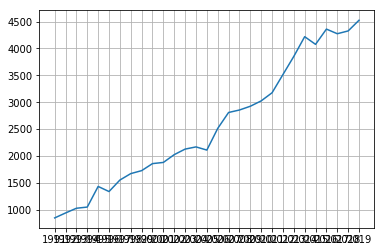

In [18]:
x,y = zip(*sorted(nyear.items()))
plt.plot(x,y)
plt.grid()
plt.show()

In [19]:
# run the model
doc_lda = lda_model[corpus]

In [20]:
# create time series

# all years where we have data
years = np.unique(corpus_df['Year'])

# init storage (as a dictionary)
popularity_all_journals = {}
popularity_by_journal = np.zeros([len(corpus_df.Journal.unique()), lda_model.num_topics])
popularity_by_journal_year = np.zeros([len(corpus_df.Journal.unique()), len(years), lda_model.num_topics])

# loop through years
for y, year in enumerate(years):
    
    # extract all papers in this year
    topic_distributions_year = topic_distributions[corpus_df['Year'] == year,:]

    # calculate topic popularity for this year
    popularity_all_journals[year] = np.sum(topic_distributions_year, axis=0) / np.sum(topic_distributions_year)
    
    # topic popularity by journal over years
    for j, journal in enumerate(corpus_df.Journal.unique()):
        jyidx = np.where(np.logical_and((corpus_df.Journal == journal), (corpus_df.Year == year)))[0]
        popularity_by_journal_year[j,y,:] = np.sum(topic_distributions[jyidx,:], axis=0) / np.sum(topic_distributions[jyidx,:])

/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [21]:
# topic popularity by journal
for j, journal in enumerate(corpus_df.Journal.unique()):
    jidx = np.where((corpus_df.Journal == journal))[0]
    popularity_by_journal[j,:] = np.sum(topic_distributions[jidx,:], axis=0) / np.sum(topic_distributions[jidx,:])

In [22]:
def calc_entropy(pmf):
    return -np.nansum(pmf * np.log(pmf))

In [23]:
#Popularity of topics by journal plot

In [24]:
def calc_KL_divergence(pmf1,pmf2):
    return -np.nansum(pmf1 * np.log(pmf2/pmf1))

In [25]:
def jensen_shannon_distance(pmf1,pmf2):
    M=0.5*(pmf1+pmf2)
    D1=calc_KL_divergence(pmf1,M)
    D2=calc_KL_divergence(pmf2,M)
    JSDiv = 0.5*D1+0.5*D2
    JSD = np.sqrt(JSDiv)
    return JSD

In [26]:
journals = corpus_df['Journal'].unique()
years = corpus_df['Year'].unique()
njournals = len(journals)
nyears = len(years)

In [27]:
# calculate JSD 
JSD_across_journals = np.full([njournals,njournals,nyears], np.nan)
year_label = []
for y, year in enumerate(years):
    year_label.append(year)
    for j1, journal1 in enumerate(journals):
        for j2, journal2 in enumerate(journals):
            JSD_across_journals[j1,j2,y] = jensen_shannon_distance(popularity_by_journal_year[j1,y,:],popularity_by_journal_year[j2,y,:])

/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


IndexError: index 13 is out of bounds for axis 0 with size 13

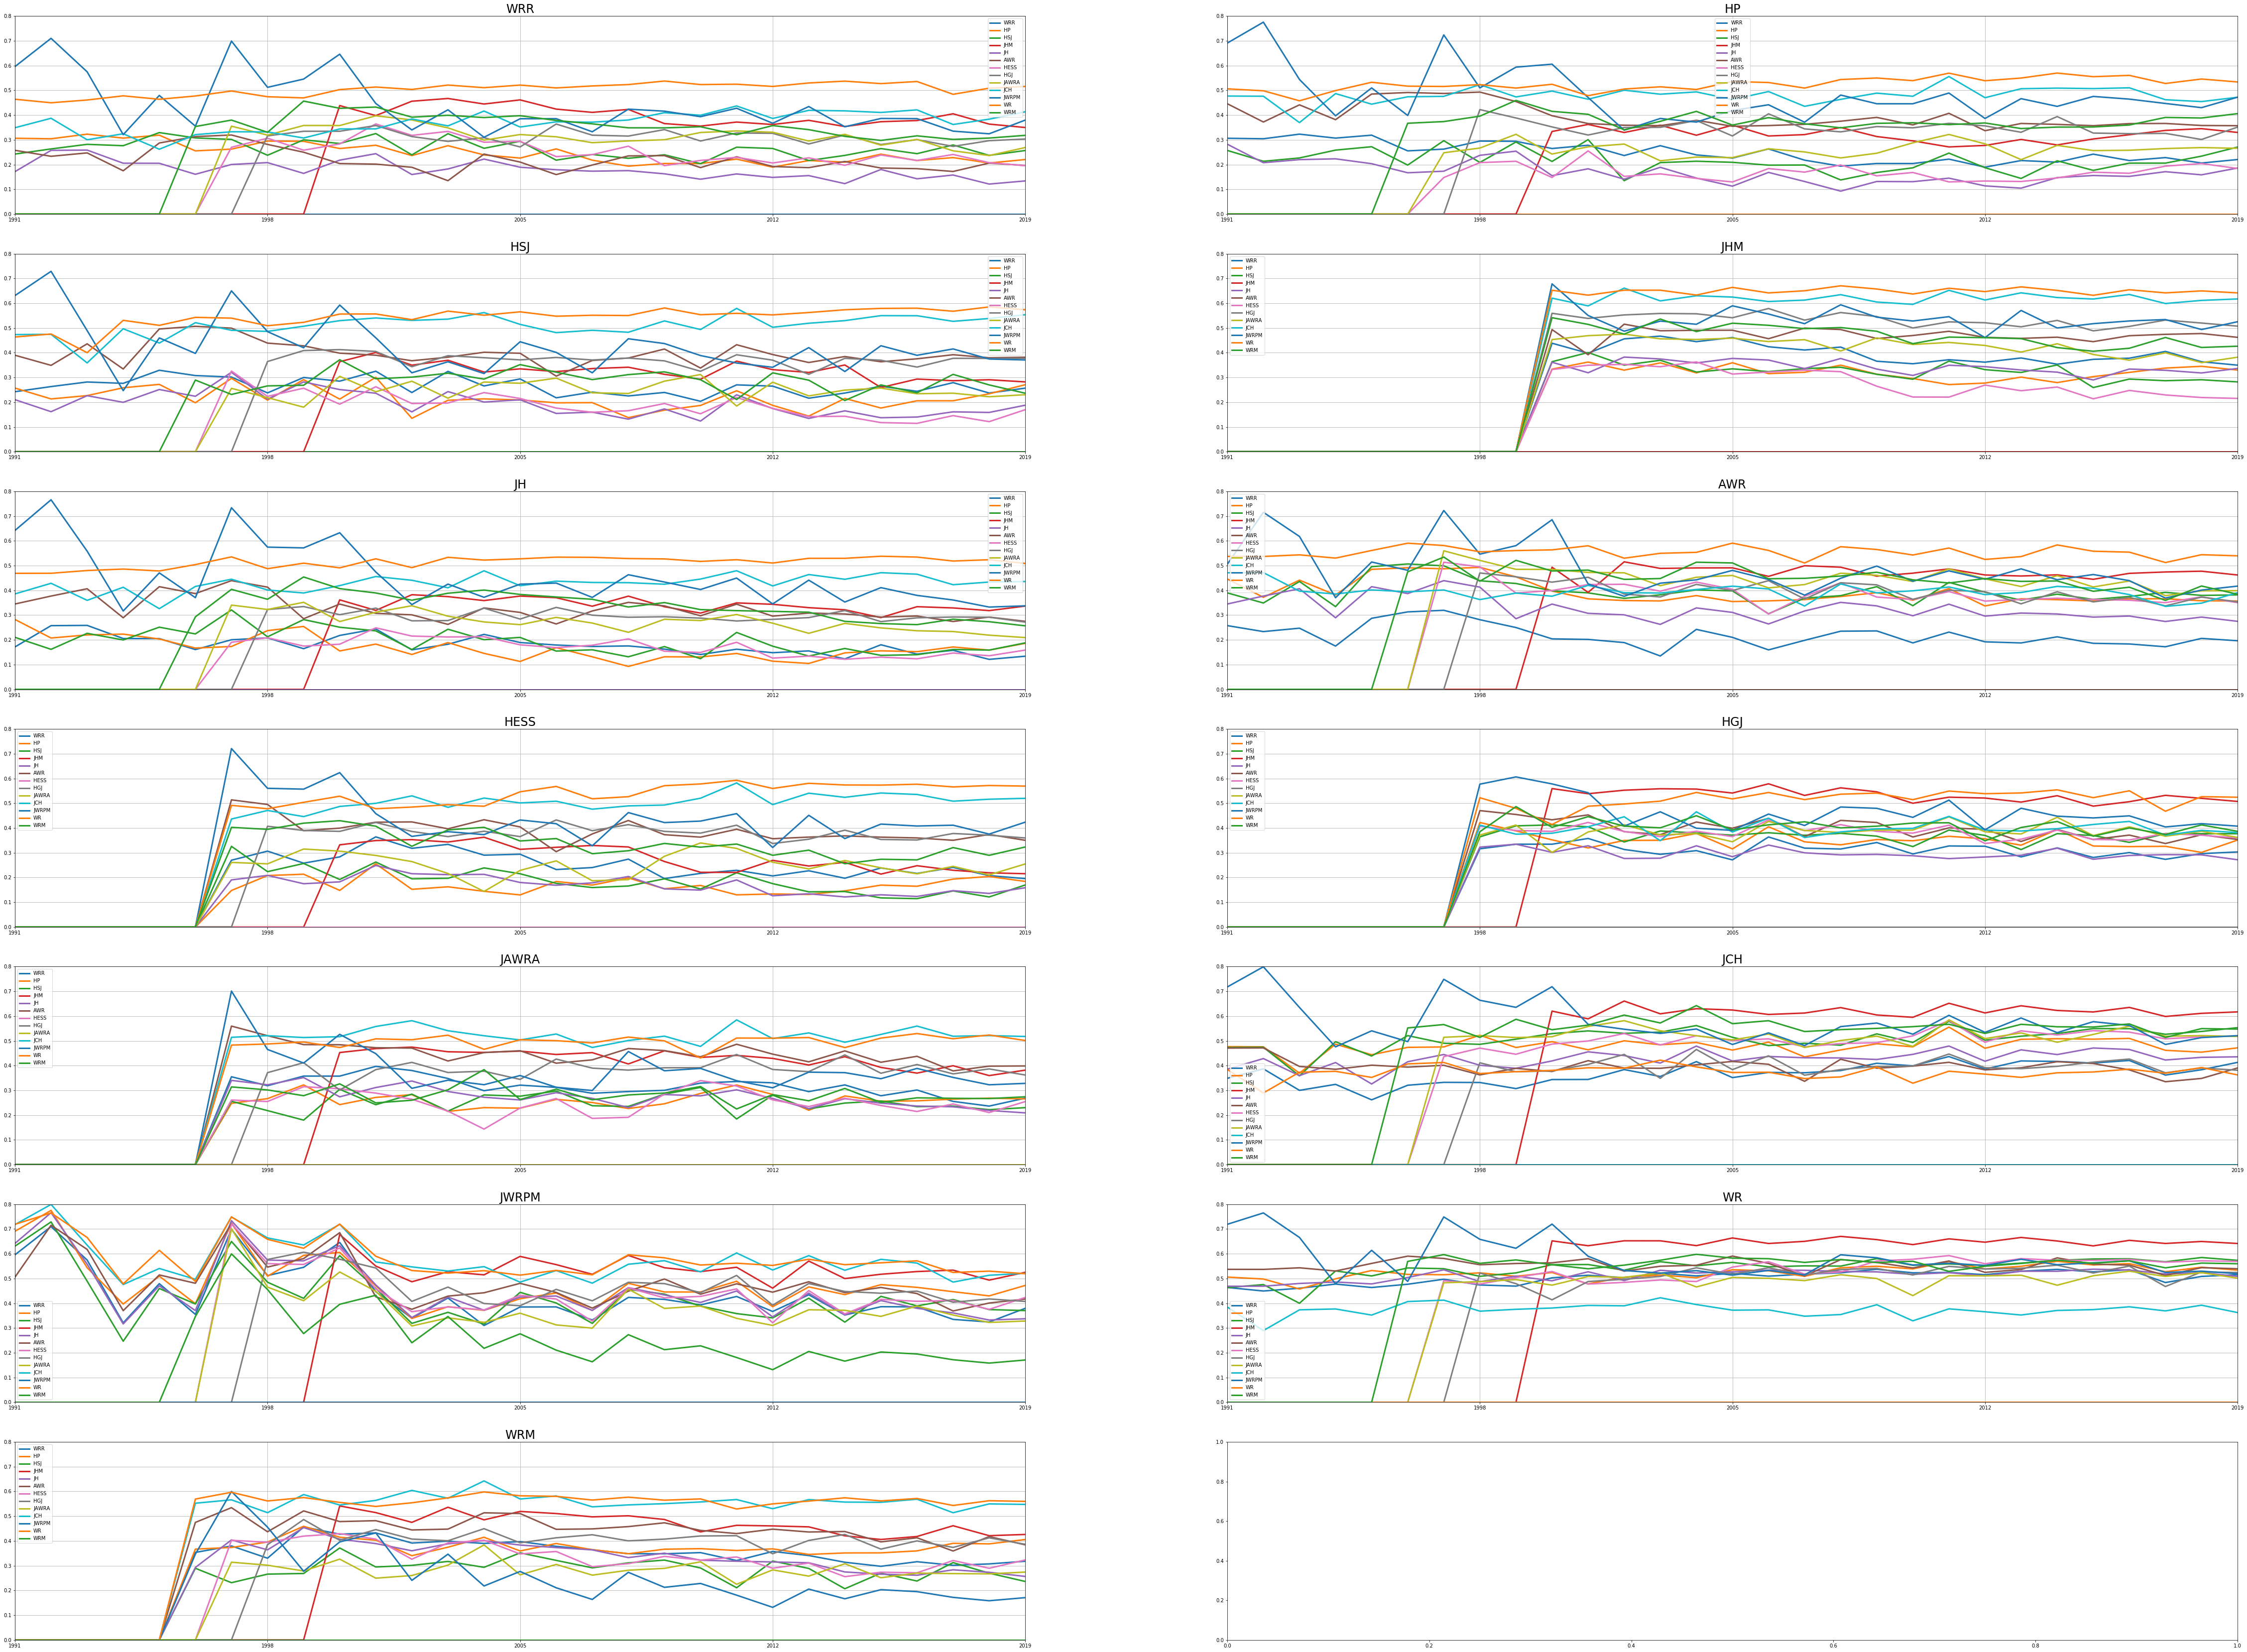

In [28]:
#plot JSD for each journal 
fig, axes = plt.subplots(7,2,figsize=(80,60))

for i, ax in enumerate(axes.flatten()):
#     if i==7:
#         ax.set_visible(False)
    ax.plot(np.sort(years), JSD_across_journals[i,:,:].transpose(),linewidth=3)
    ax.set_title(journals[i], fontsize=24)
    ax.set_ylim([0.0, 0.8])
    ax.set_xlim([0, 27])
    ax.set_xticks(np.floor(np.linspace(0,nyears-1,5)))
#     if i==3:
    ax.legend(journals)
    ax.grid()   

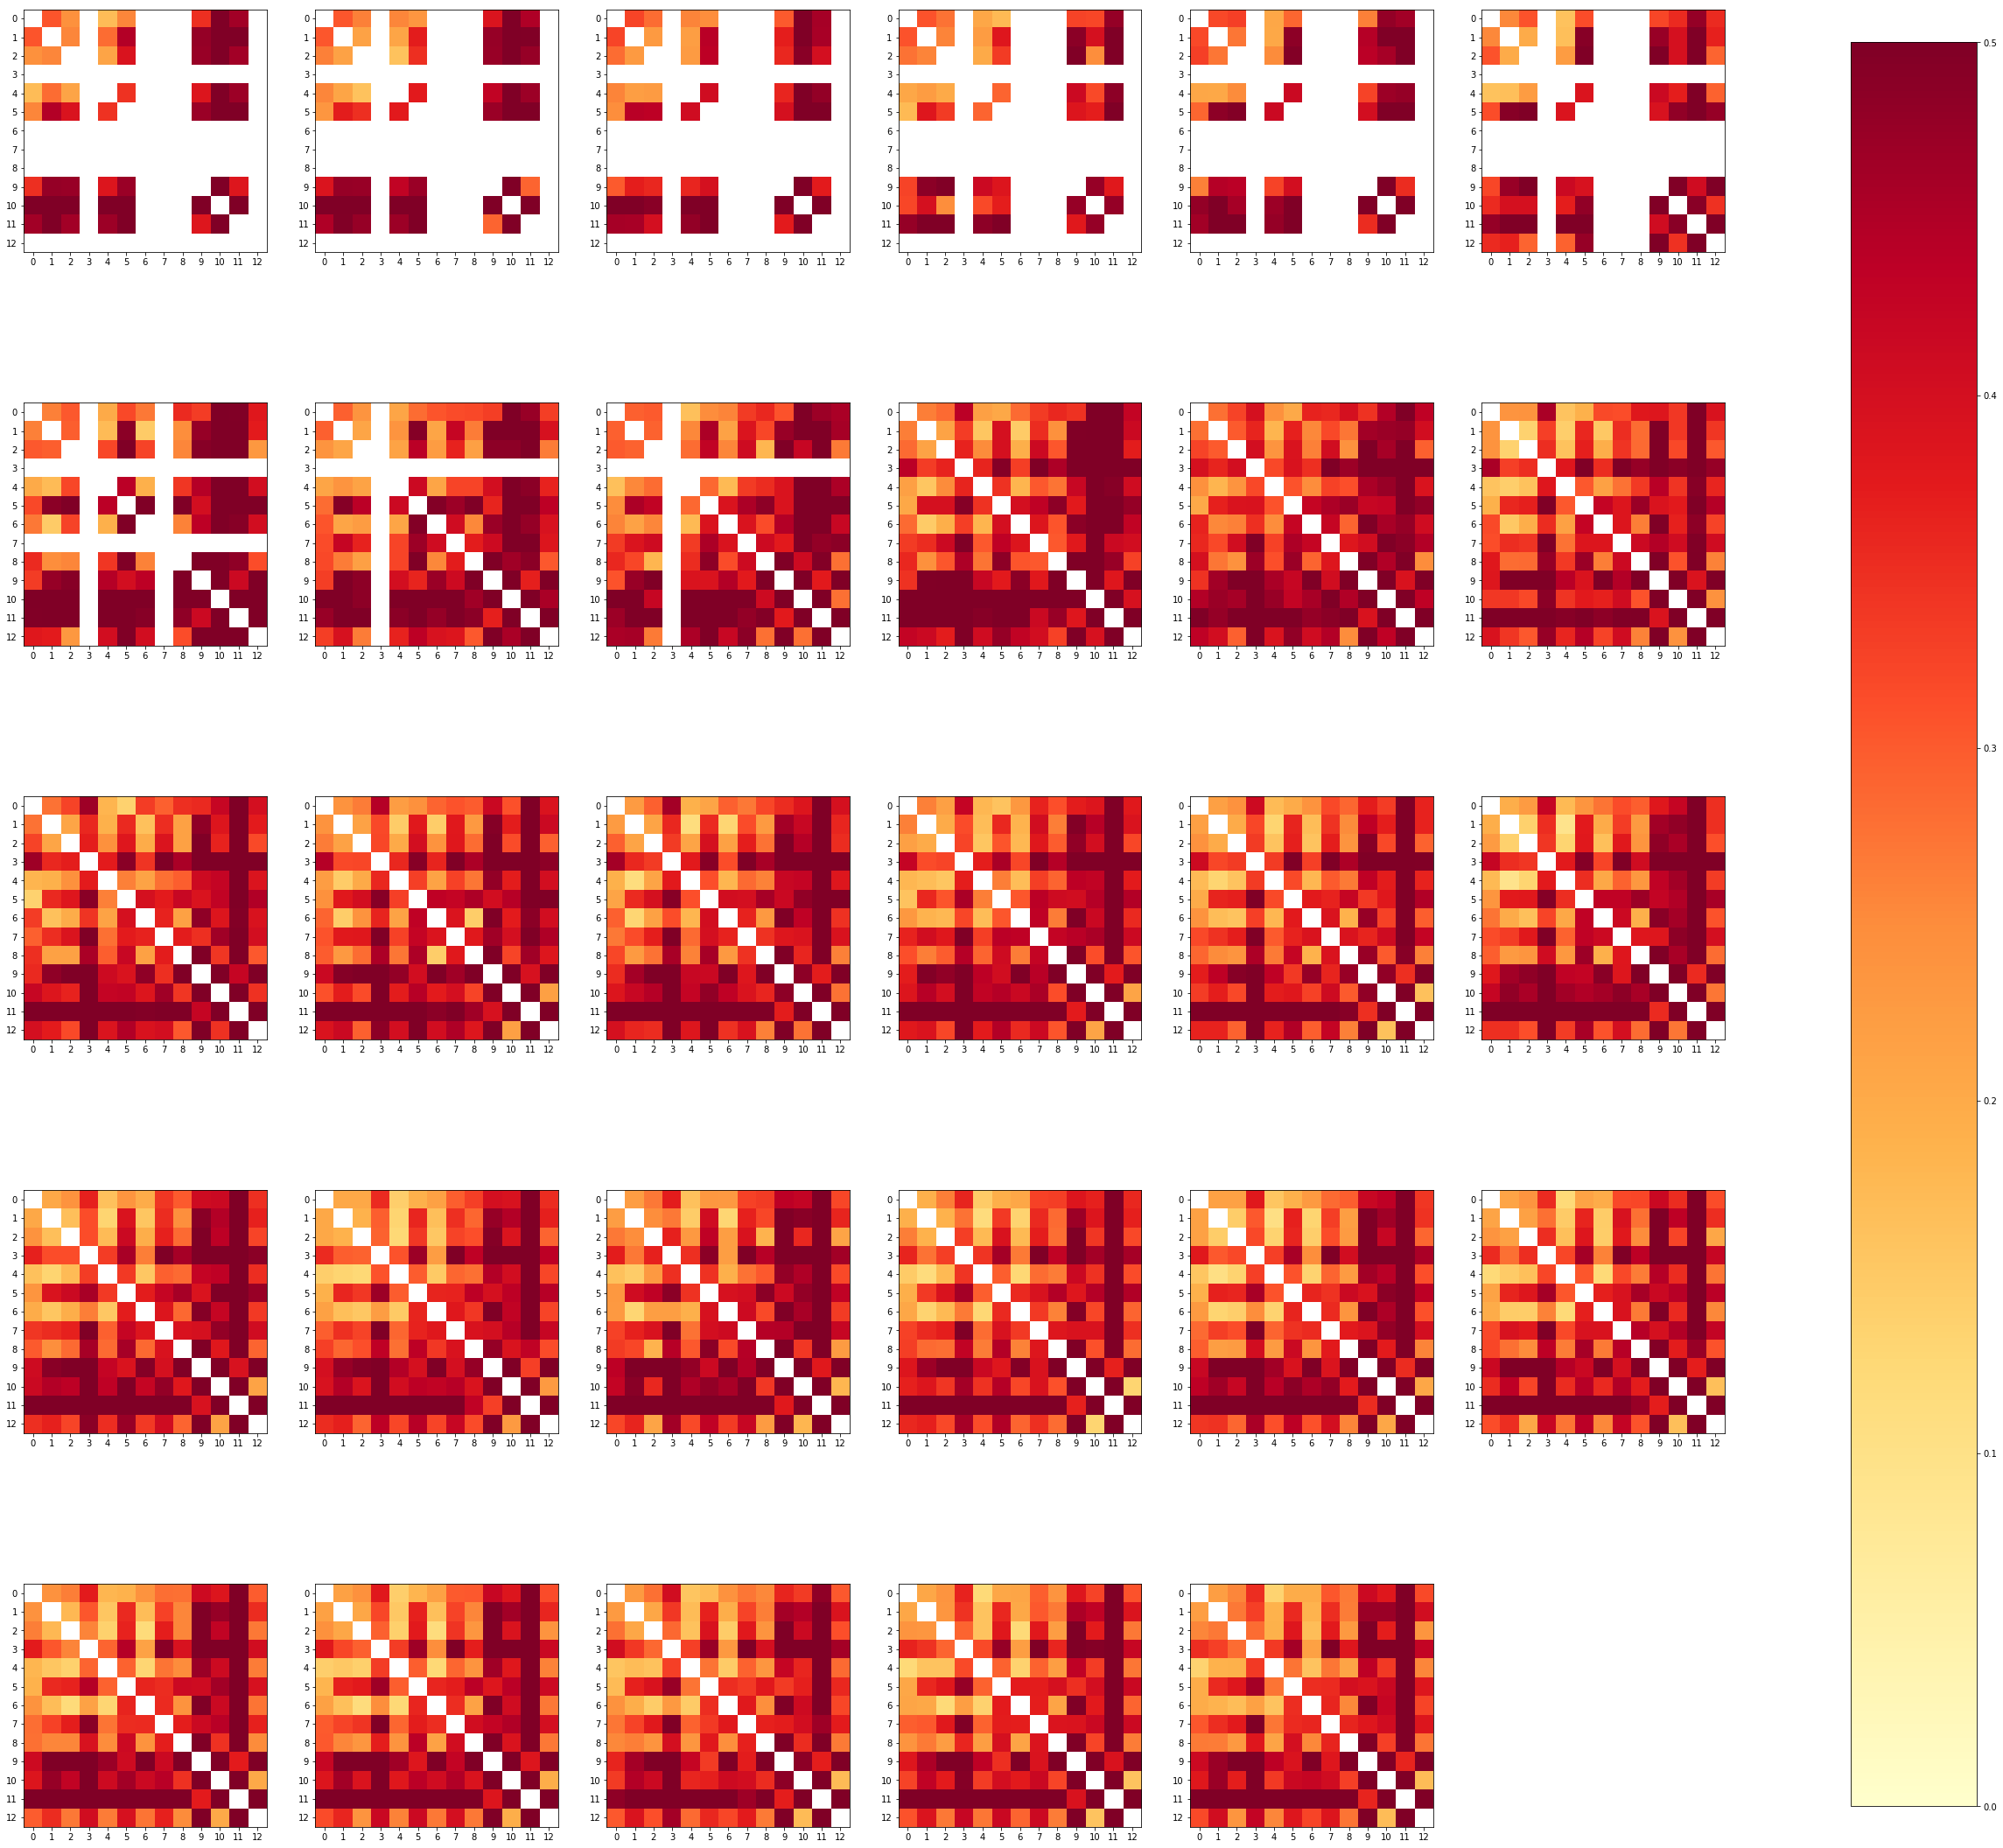

In [29]:
#plot confusion matrices for JSD over all years
fig, axes = plt.subplots(5,6, figsize=(40,40))
# fig.colorbar(res)
for y, ax in enumerate(axes.flatten()):
    if y >= nyears:
        ax.set_visible(False)
    else:
        plot_data = JSD_across_journals[:,:,y]
        plot_data[plot_data == 0] = np.nan
        conf_arr = np.array(plot_data)
        ax.set_aspect(1)    
        res = ax.imshow(np.array(conf_arr), cmap="YlOrRd", interpolation='nearest', vmin=0, vmax=0.5)
        width = njournals
        height = njournals
        ax.set_xticks(range(width))#, alphabet[:width]
        ax.set_yticks(range(height))#, alphabet[:height]
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(res, cax=cbar_ax)
plt.show()
plt.close()
# plt.savefig('confusion_matrix.png', format='png')

In [30]:
#calculate JSD over whole corpus
JSD_corpus = np.full([njournals,njournals], np.nan)
for j1, journal1 in enumerate(journals):
    for j2, journal2 in enumerate(journals):
        JSD_corpus[j1,j2] = jensen_shannon_distance(popularity_by_journal[j1,:],popularity_by_journal[j2,:])
JSD_corpus

array([[-0.        ,  0.22574638,  0.24281527,  0.40364952,  0.15962928,
         0.16211179,  0.2481821 ,  0.29779449,  0.30458322,  0.36162529,
         0.37716622,  0.50409245,  0.34556846],
       [ 0.22574638, -0.        ,  0.17259143,  0.30885045,  0.12196483,
         0.35582824,  0.13586349,  0.33788603,  0.23706084,  0.4761361 ,
         0.43086392,  0.5272028 ,  0.35914124],
       [ 0.24281527,  0.17259143, -0.        ,  0.309445  ,  0.13983044,
         0.35758898,  0.10999042,  0.34053163,  0.21694784,  0.51018942,
         0.35864208,  0.54653994,  0.25110811],
       [ 0.40364952,  0.30885045,  0.309445  , -0.        ,  0.33540715,
         0.4701373 ,  0.24888684,  0.52204304,  0.4169709 ,  0.613141  ,
         0.52009918,  0.64261785,  0.44482146],
       [ 0.15962928,  0.12196483,  0.13983044,  0.33540715, -0.        ,
         0.29042547,  0.13544255,  0.27537614,  0.2439914 ,  0.43058466,
         0.38497469,  0.51409838,  0.30940999],
       [ 0.16211179,  0.355828

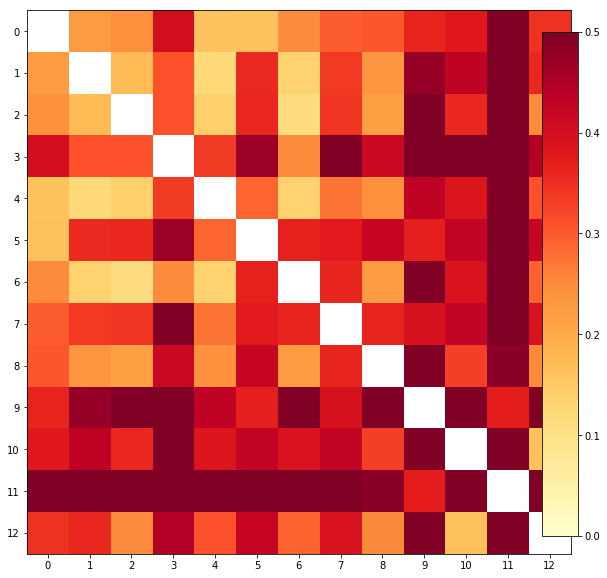

In [31]:
#plot single confusion matrix over

fig, ax = plt.subplots(1,1, figsize=(10,10))

plot_data = JSD_corpus[:,:]
plot_data[plot_data == 0] = np.nan
conf_arr_corpus = np.array(plot_data)    
res = ax.imshow(np.array(conf_arr_corpus), cmap="YlOrRd", interpolation='nearest', vmin=0, vmax=0.5)
width = njournals
height = njournals
ax.set_xticks(range(width))#, alphabet[:width]
ax.set_yticks(range(height))#, alphabet[:height]
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(res, cax=cbar_ax)

# plt.close()
# plt.savefig('confusion_matrix.png', format='png')

In [ ]:
#Spatial Distribution of Topica

#papers in countries
countries = corpus_df.Affiliation.unique()
countries

In [ ]:
# countries
countries = np.unique(corpus_df['Affiliation'])
    
#init storage 
popularity_all_countries = {}
popularity_by_countries = np.zeros([len(corpus_df.Affiliation.uniqe()), len(years), lda_model.num_topics])


# loop through years
for y, year in enumerate(years):
    
    # extract all papers in this year
    topic_distributions_year = topic_distributions[corpus_df['Year'] == year,:]

    # calculate topic popularity for this year
    popularity_all_journals[year] = np.sum(topic_distributions_year, axis=0) / np.sum(topic_distributions_year)
    
    # topic popularity by country
    for c, countries in enumerate(corpus_df.Affiliation.unique()):
        cyidx = np.where(np.logical_and((corpus_df.Affiliation == country), (corpus_df.Year == year)))[0]
        popularity_by_countries[c,y,:] = np.sum(topic_distributions[cyidx,:], axis=0) / np.sum(topic_distributions[cyidx,:])